# Spaceship Titanic
### A kaggle competition
In this notebook we will have a take at the [Spaceship Titanic competition](https://www.kaggle.com/competitions/spaceship-titanic) by Kaggle. 
We are provided with a dataset of fake data about passengers on a spaceship that disappeared in space. Half of its passenger vanished in an other dimension.
We are tasked with predicting the transportation of passengers to an other dimension.  
The data is split in two parts : train and test. The test set has no Transported category. We're supposed to make our predictions on the test set, make a csv of our test predictions and upload it to kaggle, which will evaluate our test predictions and give us a score.

# Table of Contents

## Contents

1. [Imports](#Imports)
2. [Data visualization](#Data-visualization)
3. [Feature engineering](#Feature-engineering)
4. [Feature selection](#Feature-selection)
5. [Encoding feature values](#Encoding-feature-values)
6. [Imputing NaN values](#Imputing-NaN-values)
7. [Modeling](#Modeling)
8. [Results](#Results)

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, ShuffleSplit, RandomizedSearchCV, RandomizedSearchCV
from sklearn.feature_selection import  chi2, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Data visualization

We'll first visualize the data before manipulating the data.  
Let's open the dataset. We'll combine both the training and the test data, so that our data manipulations and feature engineering applies to both the datasets.

In [2]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
df = pd.concat([df_train,df_test])
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


In [3]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

In [4]:
df.shape

(12970, 14)

In [5]:
df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
dtype: object

Let's check the distributions of the transported classes in relation to the features

In [7]:
target_value_counts = df['Transported'].value_counts()
target_value_counts

True     4378
False    4315
Name: Transported, dtype: int64

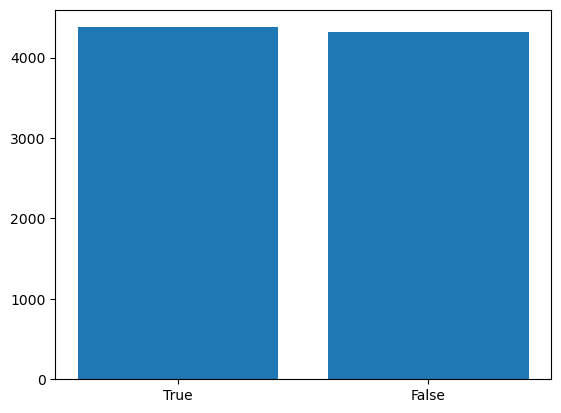

In [8]:
plt.bar(['True', 'False'], target_value_counts)
plt.show()

The count of True and False values are around the same. The target labels are balanced.

We check the number of Transported people according to numerical features

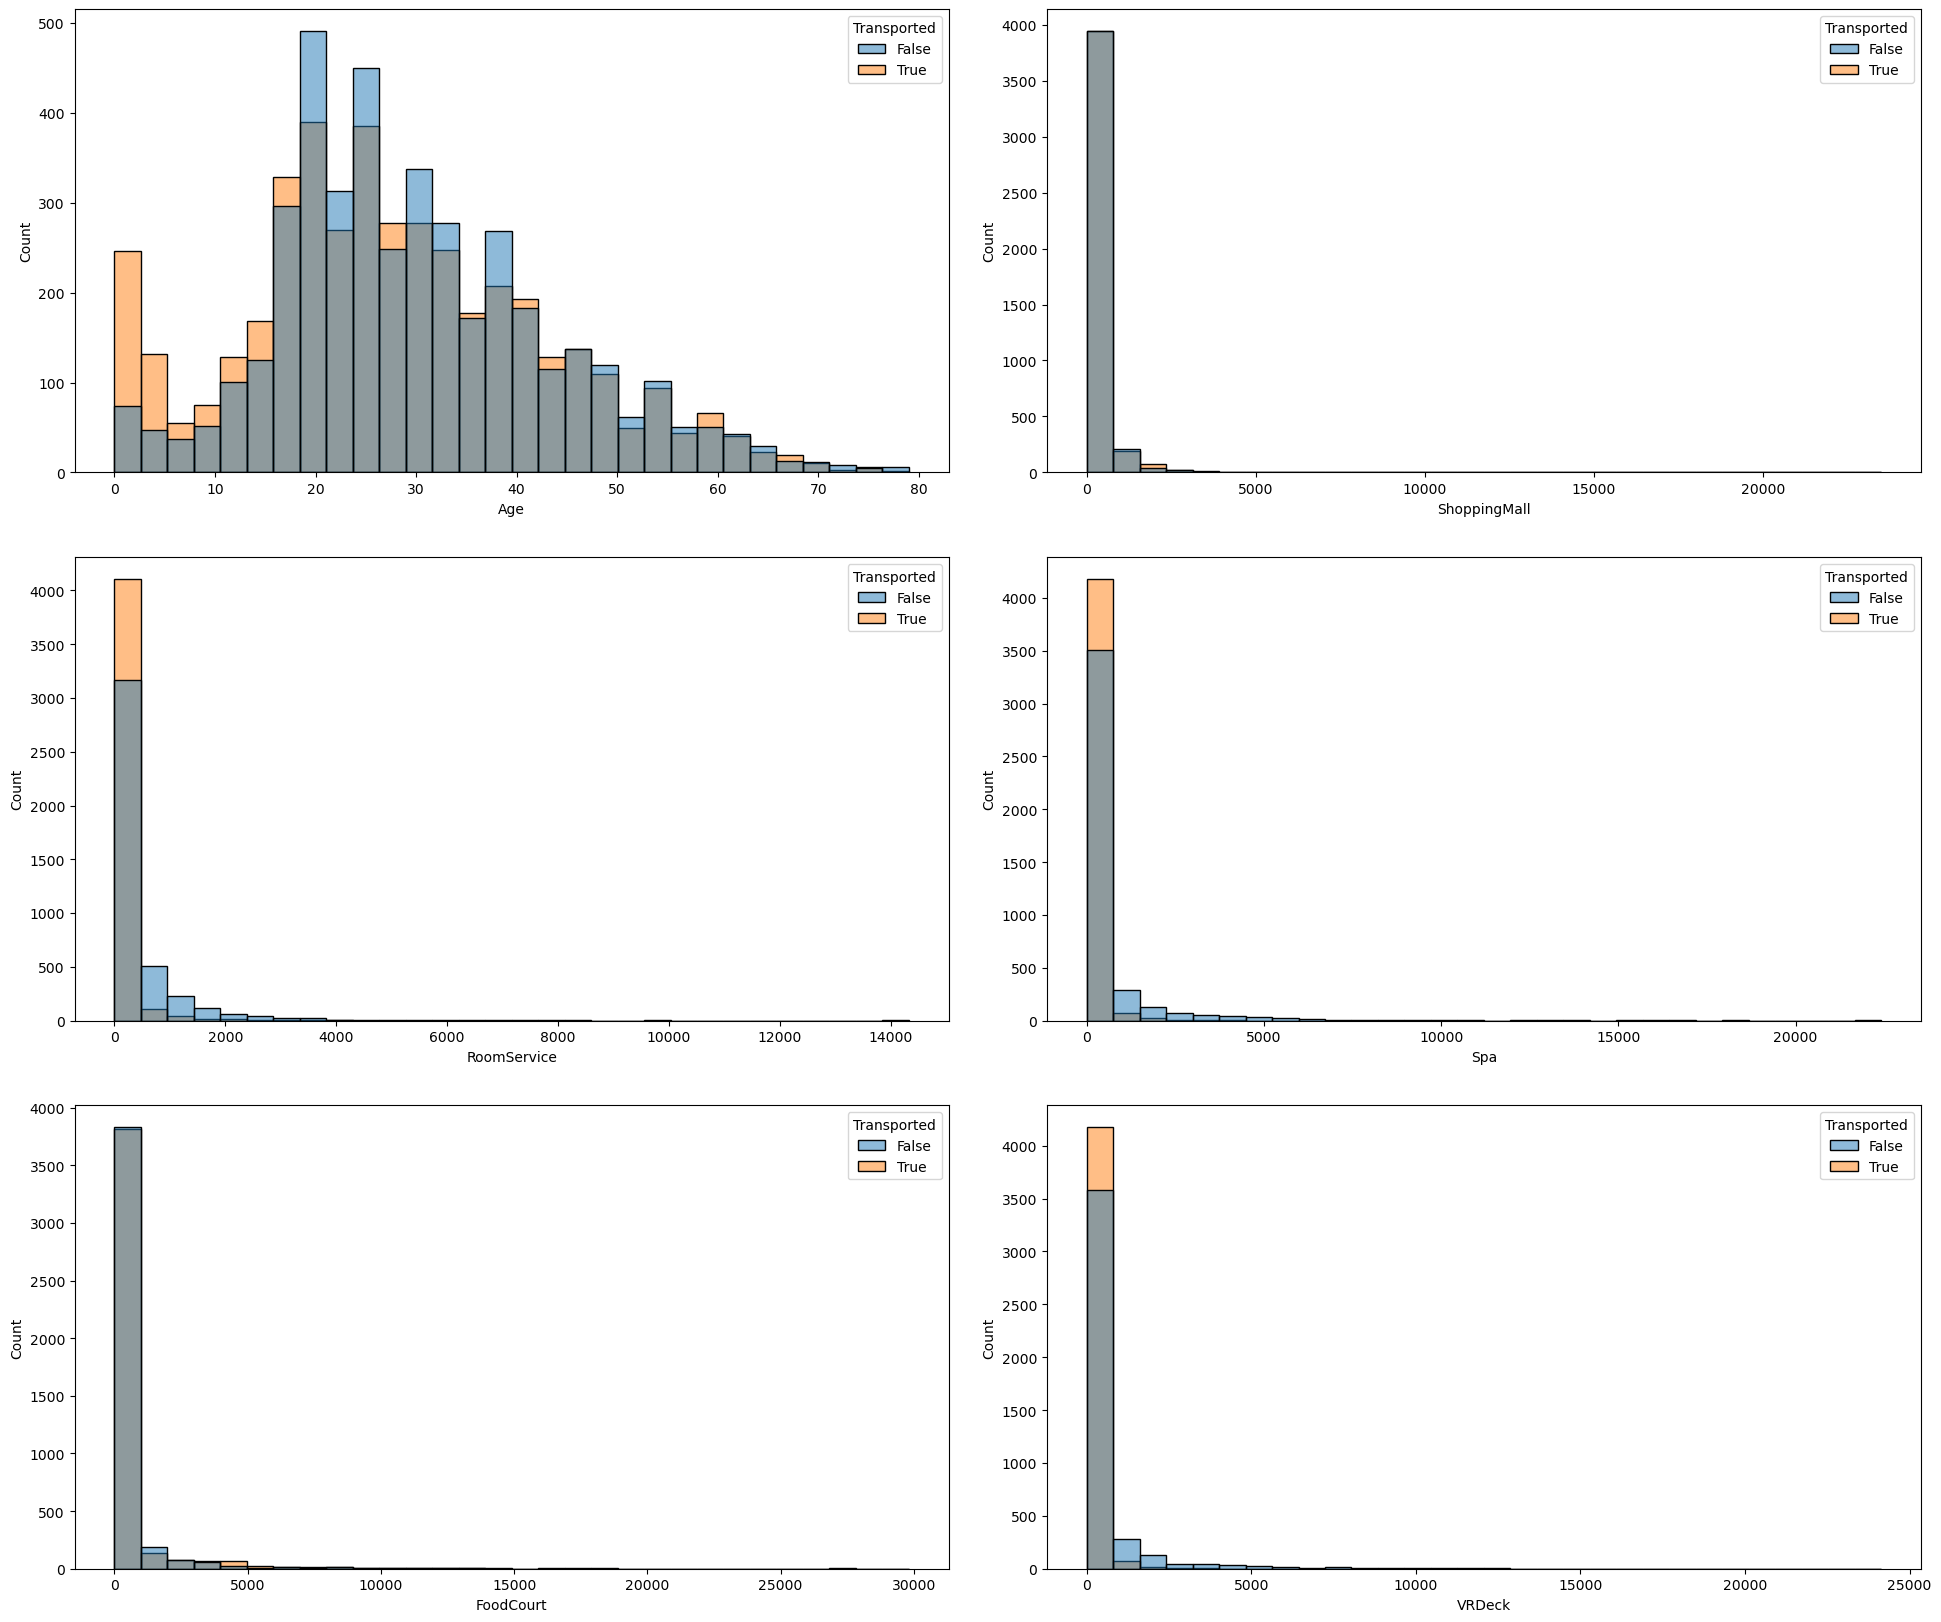

In [9]:
columns = ['Age', 'RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,17))
fig.tight_layout(pad=4)
for i,col in enumerate(columns):
    sns.histplot(data=df[[col,'Transported']].dropna(axis=0), x=col, hue="Transported", ax=axs[i%3,i//3], bins=30)
    #pos = df[df['Transported'] == 1][col]
    #neg = df[df['Transported'] == 0][col]
    #axs[i%3,i//3].hist(pos, label="Positive")
    #axs[i%3,i//3].hist(neg, label="Negative")
    #axs[i%3,i//3].legend()
    #axs[i%3,i//3].set_title(col)

plt.show()

We notice that FoodCourt and ShoppingMall share the same distribution, whether or not the person has been transported. So we could try removing that column off of our dataframe.

We create two more categories that sums the regular spendings and the luxury ones.

In [10]:
df["Regular"] = df["FoodCourt"] + df["ShoppingMall"] 
df["Luxury"] = df["RoomService"] + df["Spa"] + df["VRDeck"]

[]

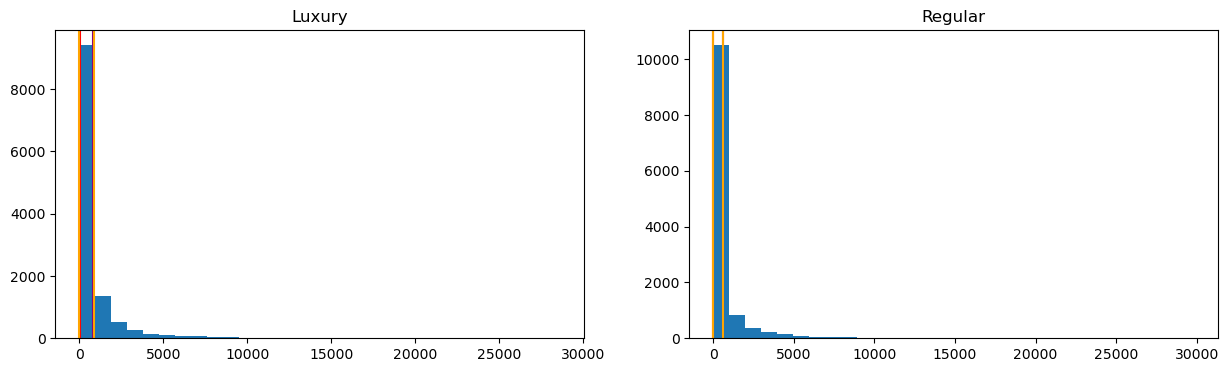

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].hist(df["Luxury"], bins=30)
axs[0].axvline(df["Luxury"].mean(), c="purple")
axs[0].axvline(df["Luxury"].median(), c="red")
axs[0].axvline(df["Luxury"].quantile(0.25), c="orange")
axs[0].axvline(df["Luxury"].quantile(0.75), c="orange")
axs[0].set_title("Luxury")

axs[1].hist(df["Regular"], bins=30)
axs[1].axvline(df["Regular"].mean(), c="purple")
axs[1].axvline(df["Regular"].median(), c="red")
axs[1].axvline(df["Regular"].quantile(0.25), c="orange")
axs[1].axvline(df["Regular"].quantile(0.75), c="orange")
axs[1].set_title("Regular")

plt.plot()

The issue with these hists is that there is a majority of people in CryoSleep & children that couldn't spend any money. So we shouldn't take them into account.

[]

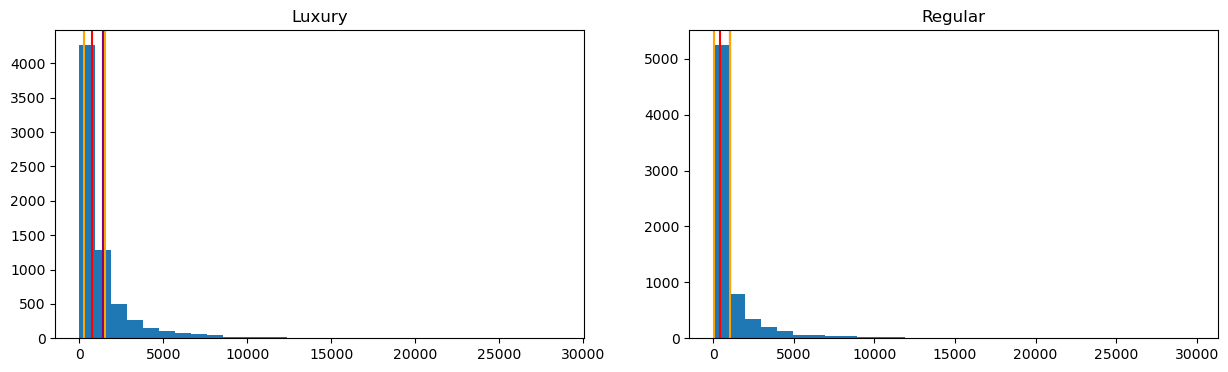

In [12]:
df_money = df[df["CryoSleep"] == False]
df_money = df_money[df_money["Age"] >= 13]

fig, axs = plt.subplots(1, 2, figsize=(15,4))

axs[0].hist(df_money["Luxury"], bins=30)
axs[0].axvline(df_money["Luxury"].mean(), c="purple")
axs[0].axvline(df_money["Luxury"].median(), c="red")
axs[0].axvline(df_money["Luxury"].quantile(0.25), c="orange")
axs[0].axvline(df_money["Luxury"].quantile(0.75), c="orange")
axs[0].set_title("Luxury")

axs[1].hist(df_money["Regular"], bins=30)
axs[1].axvline(df_money["Regular"].mean(), c="purple")
axs[1].axvline(df_money["Regular"].median(), c="red")
axs[1].axvline(df_money["Regular"].quantile(0.25), c="orange")
axs[1].axvline(df_money["Regular"].quantile(0.75), c="orange")
axs[1].set_title("Regular")

plt.plot()

Now we see the real distributions of customers on the ship. Let's now plot them according to their Transported status.

<Axes: xlabel='Regular', ylabel='Count'>

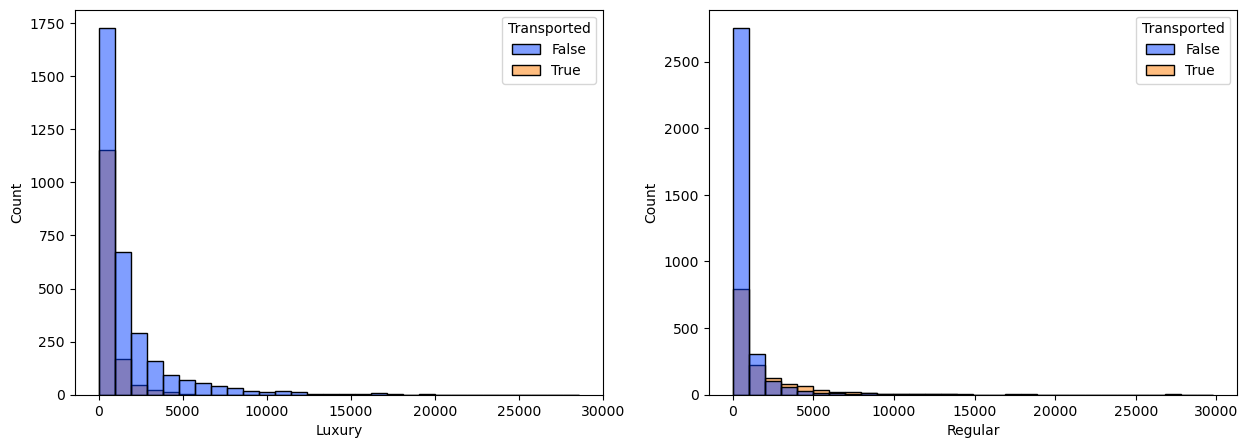

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data=df_money.set_index("PassengerId"), x="Luxury", hue="Transported", ax=axs[0], bins=30, palette="bright")
sns.histplot(data=df_money.set_index("PassengerId"), x="Regular", hue="Transported", ax=axs[1], bins=30, palette="bright")

Now we can clearly see that people who tended to spend more on didn't get transported

<Axes: xlabel='Transported', ylabel='Age'>

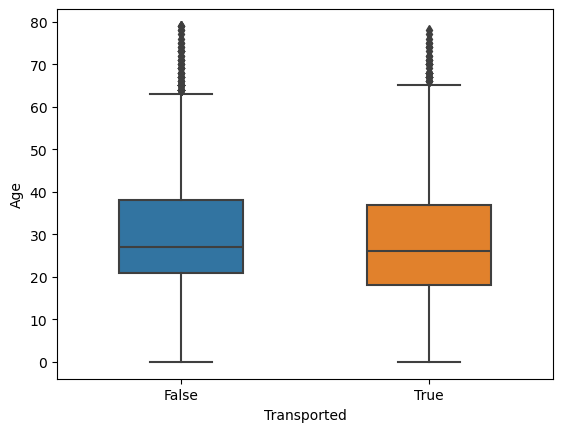

In [14]:
sns.boxplot(data=df[['Age', 'Transported']].dropna(axis=0), y='Age', x='Transported', width=0.5)

Transported people tend to be younger. The quantiles are more spaced.

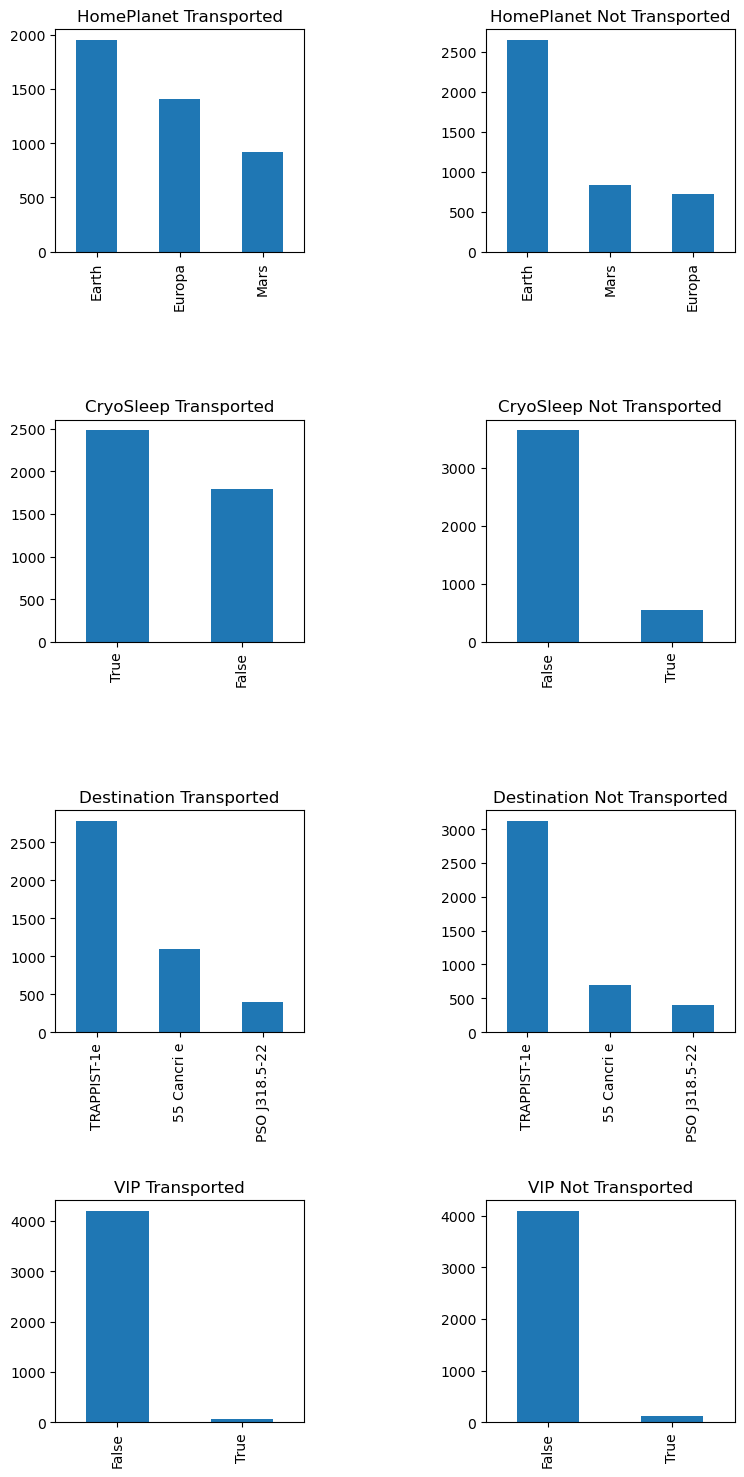

In [15]:
columns = ['HomePlanet','CryoSleep','Destination','VIP']
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,17))
fig.tight_layout(pad=10)
for i,col in enumerate(columns):
    axs[i%4,0].set_title(col+" Transported")
    df[df['Transported'] == True][col].value_counts().plot(kind='bar', ax=axs[i%4,0])
    
    axs[i%4,1].set_title(col+" Not Transported")
    df[df['Transported'] == False][col].value_counts().plot(kind='bar', ax=axs[i%4,1])

plt.show()

People in cryosleep were very less likely to be transported  
VIP didn't change the proportions of transported people. Though slightly more Not Transported people were VIP.

# Feature engineering

In [16]:
df.reset_index()

,index,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Regular,Luxury
0,0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0
1,1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0
2,2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3576.0,6807.0
3,3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1654.0,3522.0
4,4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,0.0,0.0
12966,4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,864.0,154.0
12967,4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,0.0,0.0
12968,4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,2680.0,523.0


In [17]:
df = df.reset_index().drop('index', axis=1)

In [18]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Regular,Luxury
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3576.0,6807.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1654.0,3522.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0


In [19]:
df['Group'] = df['PassengerId'].str.split('_', expand=True)[0].astype(str)

In [20]:
df['Cabin']

0           B/0/P
1           F/0/S
2           A/0/S
3           A/0/S
4           F/1/S
           ...   
12965    G/1496/S
12966         NaN
12967     D/296/P
12968     D/297/P
12969    G/1498/S
Name: Cabin, Length: 12970, dtype: object

In [21]:
df[['Deck','CabinNumber','Side']] = df['Cabin'].str.split('/', expand=True)

In [22]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Regular,Luxury,Group,Deck,CabinNumber,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0,0001,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0,0002,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3576.0,6807.0,0003,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1654.0,3522.0,0003,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0,0004,F,1,S


In [23]:
df['CabinNumber'] = df['CabinNumber'].astype(int, errors='ignore')

In [24]:
df['LastName'] = df['Name'].str.split(' ', expand=True)[1]

In [25]:
df.shape

(12970, 21)

In [26]:
df.set_index('PassengerId', inplace=True)

In [27]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Regular,Luxury,Group,Deck,CabinNumber,Side,LastName
PassengerId,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0,0001,B,0,P,Ofracculy
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0,0002,F,0,S,Vines
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3576.0,6807.0,0003,A,0,S,Susent
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1654.0,3522.0,0003,A,0,S,Susent
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0,0004,F,1,S,Santantines


In [28]:
df.dtypes

HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported      object
Regular         float64
Luxury          float64
Group            object
Deck             object
CabinNumber      object
Side             object
LastName         object
dtype: object

We then remap the outlier values to the 99th quantile.

In [29]:
def quantile_remap(df):
    quantile_values = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].quantile(0.95)
    
    for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
        num_values = df[col].values
        threshold = quantile_values[col]
        num_values = np.where(num_values > threshold, threshold, num_values)
        print(num_values)
        df[col] = num_values

In [30]:
quantile_remap(df)

[  0. 109.  43. ...   0.   0.   0.]
[   0.    9. 2670. ...    0. 2670.    0.]
[ 0. 25.  0. ...  0.  0.  0.]
[   0.  549. 1589. ...    0.    0.    0.]
[  0.  44.  49. ...   0. 523.   0.]


We'll also count the number of people in each group and the number of family members

In [31]:
n_group_members = df['Group'].value_counts().reset_index()
n_group_members.columns = ['Group', 'N_group_members']
n_group_members

,Group,N_group_members
0,6499,8
1,8728,8
2,0984,8
3,4256,8
4,6986,8
...,...,...
9275,5190,1
9276,5187,1
9277,5186,1
9278,5185,1


In [32]:
n_family_members = df['LastName'].value_counts().reset_index()
n_family_members.columns = ['LastName', 'N_family_members']
n_family_members

,LastName,N_family_members
0,Buckentry,19
1,Belley,19
2,Hinglendez,18
3,Fowlesterez,18
4,Casonston,18
...,...,...
2401,Cabraseed,1
2402,Miste,1
2403,Imotive,1
2404,Gepie,1


In [33]:
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Regular,Luxury,Group,Deck,CabinNumber,Side,LastName
PassengerId,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0,0001,B,0,P,Ofracculy
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0,0002,F,0,S,Vines
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,2670.0,0.0,1589.0,49.0,Altark Susent,False,3576.0,6807.0,0003,A,0,S,Susent
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,1589.0,193.0,Solam Susent,False,1654.0,3522.0,0003,A,0,S,Susent
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0,0004,F,1,S,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,0.0,0.0,9266,G,1496,S,Peter
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,864.0,154.0,9269,NaN,NaN,NaN,Scheron
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,0.0,0.0,9271,D,296,P,Pore


In [34]:
df = df.reset_index().merge(n_family_members, how = 'left', on = ['LastName'])
df = df.merge(n_group_members, how = 'left', on = ['Group'])
df = df.set_index('PassengerId')
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,Regular,Luxury,Group,Deck,CabinNumber,Side,LastName,N_family_members,N_group_members
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,False,0.0,0.0,0001,B,0,P,Ofracculy,3.0,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,True,34.0,702.0,0002,F,0,S,Vines,4.0,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,2670.0,0.0,1589.0,...,False,3576.0,6807.0,0003,A,0,S,Susent,7.0,2
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,1589.0,...,False,1654.0,3522.0,0003,A,0,S,Susent,7.0,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,True,221.0,870.0,0004,F,1,S,Santantines,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,9266,G,1496,S,Peter,10.0,2
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,...,NaN,864.0,154.0,9269,NaN,NaN,NaN,Scheron,6.0,1
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,9271,D,296,P,Pore,4.0,1


In [35]:
df['TotalSpendings'] = df[['Luxury','Regular']].sum(axis=1)
df

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Regular,Luxury,Group,Deck,CabinNumber,Side,LastName,N_family_members,N_group_members,TotalSpendings
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0001,B,0,P,Ofracculy,3.0,1,0.0
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,...,34.0,702.0,0002,F,0,S,Vines,4.0,1,736.0
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,2670.0,0.0,1589.0,...,3576.0,6807.0,0003,A,0,S,Susent,7.0,2,10383.0
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,1589.0,...,1654.0,3522.0,0003,A,0,S,Susent,7.0,2,5176.0
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,...,221.0,870.0,0004,F,1,S,Santantines,9.0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,...,0.0,0.0,9266,G,1496,S,Peter,10.0,2,0.0
9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,...,864.0,154.0,9269,NaN,NaN,NaN,Scheron,6.0,1,1018.0
9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,...,0.0,0.0,9271,D,296,P,Pore,4.0,1,0.0


Cabin and Name are useless now. So we drop them.

In [36]:
df = df.drop(['Cabin', 'Name'],axis=1)
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Regular,Luxury,Group,Deck,CabinNumber,Side,LastName,N_family_members,N_group_members,TotalSpendings
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0001,B,0,P,Ofracculy,3.0,1,0.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,...,34.0,702.0,0002,F,0,S,Vines,4.0,1,736.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,2670.0,0.0,1589.0,49.0,...,3576.0,6807.0,0003,A,0,S,Susent,7.0,2,10383.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,1589.0,193.0,...,1654.0,3522.0,0003,A,0,S,Susent,7.0,2,5176.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,...,221.0,870.0,0004,F,1,S,Santantines,9.0,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9266,G,1496,S,Peter,10.0,2,0.0
9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,...,864.0,154.0,9269,NaN,NaN,NaN,Scheron,6.0,1,1018.0
9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9271,D,296,P,Pore,4.0,1,0.0


In [37]:
df.dtypes

HomePlanet           object
CryoSleep            object
Destination          object
Age                 float64
VIP                  object
RoomService         float64
FoodCourt           float64
ShoppingMall        float64
Spa                 float64
VRDeck              float64
Transported          object
Regular             float64
Luxury              float64
Group                object
Deck                 object
CabinNumber          object
Side                 object
LastName             object
N_family_members    float64
N_group_members       int64
TotalSpendings      float64
dtype: object

We have many object types in our dataframe. We need to convert these values.  
Let's start by converting the cabin number.

In [38]:
df['CabinNumber'] = df['CabinNumber'].astype(int, errors='ignore')
df['CabinNumber']

PassengerId
0001_01       0
0002_01       0
0003_01       0
0003_02       0
0004_01       1
           ... 
9266_02    1496
9269_01     NaN
9271_01     296
9273_01     297
9277_01    1498
Name: CabinNumber, Length: 12970, dtype: object

# Feature selection

When we visualized the data. We saw some variables had the same distribution for the same output. So they would not influence the output.

Let's observe the difference of the data distributions between luxury/regular vs services

In [39]:
df.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Regular',
       'Luxury', 'Group', 'Deck', 'CabinNumber', 'Side', 'LastName',
       'N_family_members', 'N_group_members', 'TotalSpendings'],
      dtype='object')

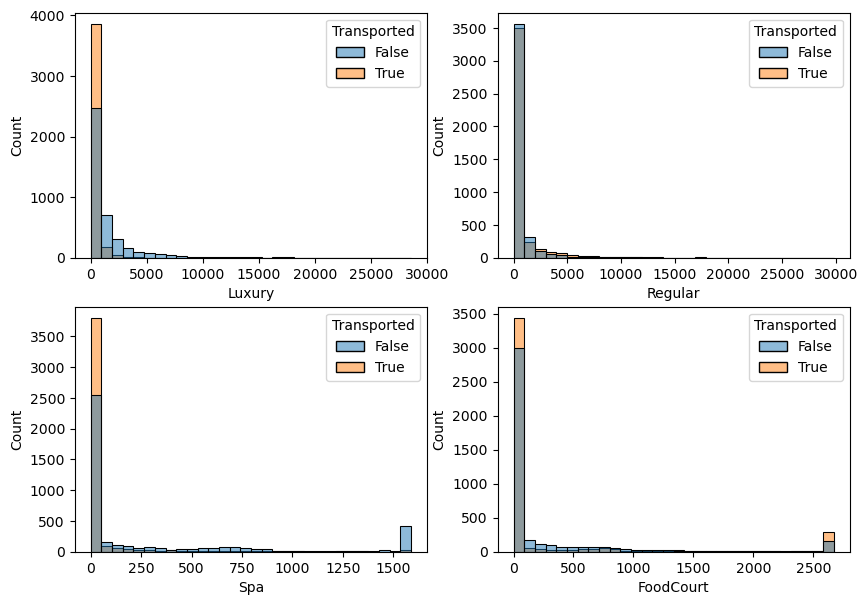

In [40]:
fig, axs = plt.subplots(2,2, figsize=(10,7))
sns.histplot(data=df[['Luxury','Transported']].dropna(axis=0), x='Luxury', hue='Transported', bins=30, ax=axs[0][0])
sns.histplot(data=df[['Regular','Transported']].dropna(axis=0), x='Regular', hue='Transported', bins=30, ax=axs[0][1])
sns.histplot(data=df[['Spa','Transported']].dropna(axis=0), x='Spa', hue='Transported', bins=30, ax=axs[1][0])
sns.histplot(data=df[['FoodCourt','Transported']].dropna(axis=0), x='FoodCourt', hue='Transported', bins=30, ax=axs[1][1])
plt.show()

The differences are more showing when comparing Luxury/Regular spendings vs service by service. As they're combinations of the same data, we can drop the services columns and keep the Luxury/Regular ones.

In [41]:
df = df.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1)

# Encoding feature values

We will now encode the string values to numerical values, using :
- the LabelEncoder for the label (Transported column)
- the OrdinalEncoder for non numerical values
  
OrdinalEncoder is usually used with data that can be ordered. In my case, because I want to use a RandomForest, I figured I can allow myself to use OrdinalEncoder for every categorical feature.

In [42]:
label_enc = LabelEncoder()
ord_enc = OrdinalEncoder()
oh_enc = OneHotEncoder(drop='first', sparse_output=False)

LabelEncoder encodes Nan values. However we need to keep them, in order to test them at the end. So we'll add an other category that will encode nan as well.

In [43]:
label_enc.fit([True,False])

LabelEncoder()

In [44]:
label_enc.classes_, label_enc.transform(label_enc.classes_)

(array([False,  True]), array([0, 1]))

In [45]:
df = df.apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))
df['Transported'].notna().sum(), df['Transported'].isna().sum()

(8693, 4277)

Then we'll encode and transform with the ordinal encoder to encode the categorical values into numbers. Because I plan on making a Random Forest, I allow myself to use the ordinal encoder also for unordered values, as they'll just be grouped in each node and compared

In [46]:
df[['HomePlanet','CryoSleep','Destination','LastName','Deck','Side','VIP']] = ord_enc.fit_transform(df[['HomePlanet','CryoSleep','Destination','LastName','Deck','Side','VIP']])

We finally split the dataframe back into the test and train sets.

# Imputing NaN values

In [47]:
df[['TotalSpendings','CryoSleep']].groupby('CryoSleep').value_counts()

CryoSleep  TotalSpendings
0.0        0                  804
           476                 72
           455                 53
           470                 50
           570                 47
                             ... 
           1733                 1
           1732                 1
           1731                 1
           1495                 1
1.0        0                 4581
Length: 2963, dtype: int64

People in CryoSleep couldn't spend money on the starship, so NaN values in the spendings columns will be 0

In [48]:
df[df['Age'] < 13]['TotalSpendings'].sum()

0

Children couldn't spend money either, so it goes the same for them.

In [49]:
df["Luxury"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["Luxury"].astype(float))
df["Regular"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["Regular"].astype(float))
df["TotalSpendings"] = np.where((df["Age"] < 13) | (df["CryoSleep"] == True), 0.0, df["TotalSpendings"].astype(float))
print(df[df['CryoSleep'] == True][['Luxury', 'TotalSpendings', 'Regular']].sum())
print(df[df['Age'] < 13][['Luxury', 'TotalSpendings', 'Regular']].sum())

Luxury            0.0
TotalSpendings    0.0
Regular           0.0
dtype: float64
Luxury            0.0
TotalSpendings    0.0
Regular           0.0
dtype: float64


We also saw that the majority of people didn't spend on Luxury and regular services. So the majority of NaNs should be low in Luxury low in Regular.

Using kNNImputer, we can impute NaN values using the kNN algorithm.

In [50]:
imp = KNNImputer()

In [51]:
cols_wo_class = list(df.columns)
cols_wo_class.remove('Transported')

df[cols_wo_class] = imp.fit_transform(df[cols_wo_class])

# Modeling

We will now build our random forest, and perform a grid search to find the best parameters for it. I decided to search for optimal values for the max depth, criterion and class weight parameters.

In [52]:
df_test = df[df['Transported'].isna()]
df_train = df[df['Transported'].notna()]
(df_train.shape, df_test.shape)

((8693, 16), (4277, 16))

In [53]:
x_train = df_train.drop('Transported', axis=1)
y_train = df_train['Transported']

In [54]:
df_test = df_test.drop('Transported', axis=1)

## LGBM

In [55]:
from lightgbm import LGBMClassifier

In [56]:
booster = LGBMClassifier(random_state=0, n_jobs=-1)

In [57]:
shuffle = ShuffleSplit(n_splits=10, test_size=0.4)

In [58]:
scores = cross_val_score(booster, x_train, y_train, scoring='accuracy', n_jobs=-1, cv=shuffle)
print(scores)
print(np.mean(scores))

[0.80448534 0.81023577 0.79787234 0.80391029 0.80304773 0.80419781
 0.81224842 0.8119609  0.79844738 0.80333525]
0.8049741230592294


We got 80%. Let's try grid_searching.

In [59]:
gs = GridSearchCV(
    booster,
    {
        "n_estimators":[100,50,10],
        "learning_rate":[0.1, 1e-2, 1e-3],
        "num_leaves":[2,10,30],
        "objective":["binary"]
    },
    scoring="accuracy",
    n_jobs=-1,
    cv=shuffle
)

In [60]:
#This cell takes a minute to run
gs.fit(x_train,y_train)
gs.score(x_train,y_train)

0.858276774416197

In [61]:
gs.best_params_

{'learning_rate': 0.1,
 'n_estimators': 50,
 'num_leaves': 30,
 'objective': 'binary'}

In [62]:
best_booster = gs.best_estimator_

In [63]:
scores = cross_val_score(booster, x_train, y_train, scoring='accuracy', n_jobs=-1, cv=shuffle)
print(scores)
print(np.mean(scores))

[0.80448534 0.8093732  0.79873491 0.81771133 0.79413456 0.81081081
 0.80764807 0.80851064 0.79240943 0.80707303]
0.8050891316848764


In [64]:
pred = best_booster.predict(df_test)

# Results

We'll now write our results to a csv file and upload it to Kaggle

In [65]:
results = pd.DataFrame(np.vectorize(lambda x:bool(x))(pred), index=df_test.index, columns=['Transported'])
results.to_csv('submission.csv')
results

,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,True
9271_01,True


TODO : PCA, FS++, FE++, DNN, RandomizedSearchCV, HalvingSearchCV